In [1]:
### Import libraries 
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, MaxPooling2D, ELU, Activation
from keras.layers.convolutional import Conv2D


Using TensorFlow backend.


In [2]:
### Define global variables
data_path = "."
csv_file_name  = "driving_log.csv"
csv_file = data_path + '/' + csv_file_name
print (csv_file)

./driving_log.csv


In [3]:
### Read CSV 
### Uses all the 3 Camera Data, with Steering Angle Augmentation
def read_csv(file_name):
    images = []
    angles = []
    
    img_count = 0
    adj_count = 0
    
    with open(file_name) as csvfile:
        reader = csv.DictReader(csvfile)
        delta = .35 # Angle correction for left and right images
        
        for line in reader:
            img_count += 1
            #print(line)
            angle = float(line['steering'])
            #print (angle)
            if (angle > delta or angle < -delta):
                images.append(line['center'])
                angles.append(angle)
                images.append(line['left'].strip())
                angles.append(angle + delta)
                images.append(line['right'].strip())
                angles.append(angle - delta)
                adj_count += 1
    print ('Image count, Interested image count :', img_count, adj_count)
    print ('Total images :', len(images))
    print ('Total angles :', len(angles))
    return images, angles

In [4]:
### Raw images read from csv file 
images, angles = read_csv(csv_file_name)

Image count, Interested image count : 7575 813
Total images : 2439
Total angles : 2439


In [5]:
### Pre process the raw data
def pre_process(image, angle, toShow):
    
    img = cv2.imread(image) 
    if (toShow == True):
        print('Original Image dimensions:', img.shape,"steering", angle)
        plt.imshow(img)
        plt.show()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    ### Does the random Brightness adjustment
    img[:,:,2] = img[:,:,2]*random_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    crop_img = img[40:130]
    
    if (toShow == True):
        print('dimensions:', crop_img.shape,"steering", angle)
        plt.imshow(crop_img)
        plt.show()
    
    ### Image cropped, resized to remove unwanted data
    height, width = crop_img.shape[:2]
    new_width = int(width/2)
    new_height = int(height/2)
    resized_image = cv2.resize(crop_img,(new_width, new_height),
                               fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

    ### Random image flip with streeing angle flip
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        # flip the image and reverse the steering angle
        flipped_image = cv2.flip(resized_image, 1)
        flipped_steering = angle*(-1)
        img = flipped_image
        angle = flipped_steering
        
        if (toShow == True):
            plt.imshow(flipped_image)
            plt.show()
    else:
        img = resized_image
            
    return img, angle

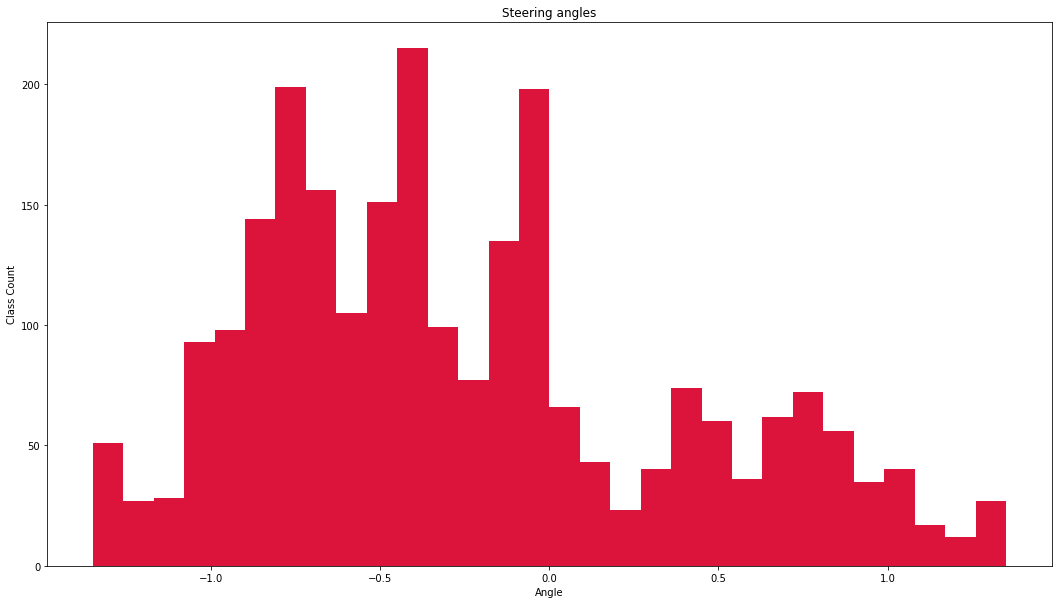

In [6]:
plt.figure(figsize=(18, 10))
plt.hist(angles, bins=30, color='crimson')
plt.title("Steering angles")
plt.xlabel("Angle")
plt.ylabel("Class Count")
plt.show()

Original Image dimensions: (160, 320, 3) steering 0.4194869


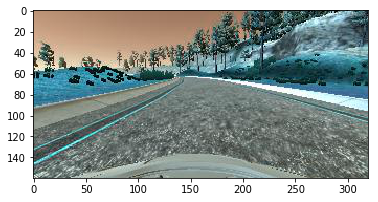

dimensions: (90, 320, 3) steering 0.4194869


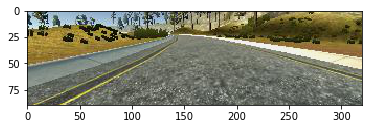

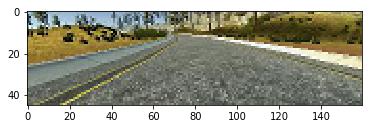

In [7]:
### Show image original, cropped, flipped 
index = 201
img, angle = pre_process(images[index], angles[index], True)
plt.imshow(img)
plt.show()

In [8]:
### Takes one image at a time, and does pre-processing
def process_data(images, angles):
    
    for i in range(len(images)):
        images[i], angles[i] = pre_process(images[i], angles[i], False)
    
    plt.imshow(images[index])
    plt.show()

    x = np.array(images)
    y = np.vstack(angles)
    
    return x, y
    

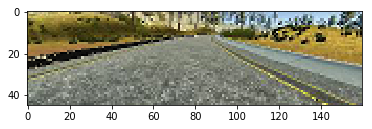

In [9]:
### x is the processed Camera Images and y are the Steering Angles
x,y = process_data(images, angles)

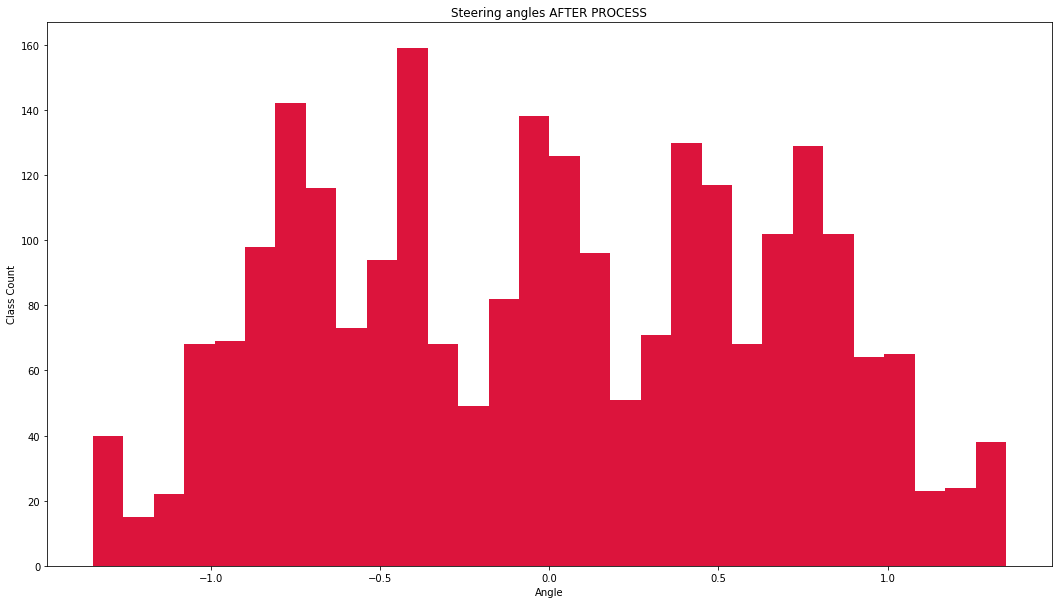

In [10]:
### Takes one image at a time, and does pre-processing
plt.figure(figsize=(18, 10))
plt.hist(y, bins=30, color='crimson')
plt.title("Steering angles AFTER PROCESS")
plt.xlabel("Angle")
plt.ylabel("Class Count")
plt.show()

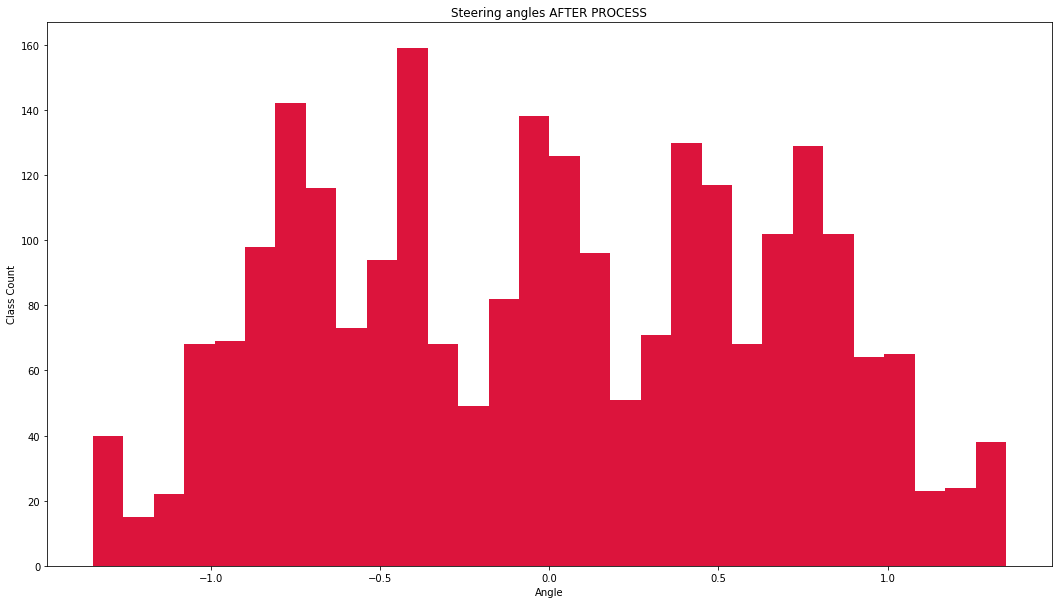

In [11]:
plt.figure(figsize=(18, 10))
plt.hist(y, bins=30, color='crimson')
plt.title("Steering angles AFTER PROCESS")
plt.xlabel("Angle")
plt.ylabel("Class Count")
plt.show()

In [12]:
### Used Comma AI CNN model
channels, height, width = 3, 45, 160  # image format
    
model = Sequential()
model.add(Lambda(lambda x: x/255. - 0.5,
        input_shape=(height, width, channels),
        output_shape=(height, width, channels)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
              
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
              
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()
              
model.compile(optimizer="adam", loss="mse", metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 45, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 43, 158, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 19, 77, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 38, 32)         0         
__________

In [13]:
### Train and Validation data split. 20% used for Validation
X_train, x_val, Y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=3252)

In [14]:
### Tuning parameters 
epochs = 10
batch_size = 128

In [15]:
### Generators/yeild for better memory usage, faster processing
def generate_train_batch(X, Y, batch_size):
    
    total = (len(y) // batch_size ) * batch_size
    # number of images in the training set
    num_images = len(X)
    # create a random index
    random_index = np.random.choice(num_images, size=batch_size, replace=False)
    while True:
        # select the random images and labels with this random index
        features_batch = X[random_index,:]
        labels_batch = Y[random_index]  
        yield features_batch, labels_batch

In [ ]:
train_generator = generate_train_batch(X_train, Y_train, batch_size)

In [ ]:
### Used fit generator 
history = model.fit_generator(train_generator,
                              len(X_train),
                                  epochs,
                                  validation_data=(x_val,y_val),
                                  nb_val_samples=len(x_val))

/Users/rthirumu/miniconda3/envs/Tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1951, 10, validation_steps=488, validation_data=(array([[[...)`
  


Epoch 1/10
1951/1951 [==============================] - 1946s - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 2/10
1379/1951 [====================>.........] - ETA: 580s - loss: 0.0206 - mean_squared_error: 0.0206

In [ ]:
### Model data save in model.h5, used in drive.py
model.save('model.h5')